In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

# import personal modules
sys.path.append('../modules') # Path to modules
from preprocess_dataframes import combine_ivt_ar_prec_df
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
# Set up paths
server = "skyriver"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
community_lst = lbl1
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of extents for each community
dx = 0.5 # this works for supplemental zoom in
dy = 0.5 # this works for supplemental zoom in

ext_lst = []
for x,y in zip(xs, ys):
    ext_lst.append([x-dx, x+dx, y-dy, y+dy])

ext_lst

[[-135.9519, -134.9519, 57.6122, 58.6122],
 [-135.8277, -134.8277, 58.9538, 59.9538],
 [-136.3894, -135.3894, 58.8988, 59.8988],
 [-140.171, -139.171, 59.0121, 60.0121],
 [-133.6358, -132.6358, 54.9769, 55.9769],
 [-132.9009, -131.9009, 55.04, 56.04]]

In [4]:
temporal_res = 'daily'
fname = path_to_data + 'preprocessed/SEAK-WRF_PCPT_{0}_composite.nc'.format(temporal_res)
prec_comp  = xr.open_dataset(fname)
## calculate average of all 6 communities
prec_mean = prec_comp.mean('community')

## subtract the mean from the original composites
prec_diff = prec_comp - prec_mean

In [5]:
## ivt composites
fname = path_to_data + '/preprocessed/ERA5_ivt_daily.nc'
ivt_comp = xr.open_dataset(fname)
ivt_comp

<xarray.Dataset>
Dimensions:    (lon: 281, lat: 245, community: 6, lag: 5)
Coordinates:
  * lon        (lon) float32 -180.0 -179.8 -179.5 ... -110.5 -110.2 -110.0
  * lat        (lat) float32 80.0 79.75 79.5 79.25 ... 19.75 19.5 19.25 19.0
  * lag        (lag) int64 -4 -3 -2 -1 0
  * community  (community) object 'Hoonah' 'Skagway' ... 'Craig' 'Kasaan'
Data variables:
    IVTv       (community, lag, lat, lon) float32 ...
    IVTu       (community, lag, lat, lon) float32 ...
    IVT        (community, lag, lat, lon) float32 ...

### Load Precipitation time series

In [6]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'

fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
df = pd.read_csv(fname)
df = df.drop(['time'], axis=1) # do not need this for percentiles or box plots
df = df.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation

fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
ar_df = pd.read_csv(fname) # read in AR dates
# append AR dates to current df
df['AR'] = ar_df.AR
# select only rows with AR date
idx = (df.AR > 0)
df = df.loc[idx]
df = df.drop(['AR'], axis=1)

# make df into tidy df
df_tidy = df.stack().reset_index()
mapping = {df_tidy.columns[0]:'ID', df_tidy.columns[1]: 'Community', df_tidy.columns[2]:'Precipitation',}
df_tidy = df_tidy.rename(columns=mapping)
df_tidy = df_tidy.drop(['ID'], axis=1)
df_tidy['Precipitation'] = df_tidy['Precipitation'].apply(lambda x: x / 25.4) #convert precip from mm to inch x/25.4
# df_tidy

### Load elevation data

In [7]:
## Open GMTED2010 7.5 arc second elevation data
elev = xr.open_dataset(path_to_data + 'preprocessed/seak_gmted_mea075.nc')

## Plot Precitation Composites

In [8]:
# Set up projection
mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = elev.lat
lons = elev.lon
dx = np.arange(lons.min().round(),lons.max().round()+0.25,+0.25)
dy = np.arange(lats.min().round(),lats.max().round()+0.25,+0.25)

ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

4.072805
6.1237793
6.165018
4.875964
3.6590986
2.8544524


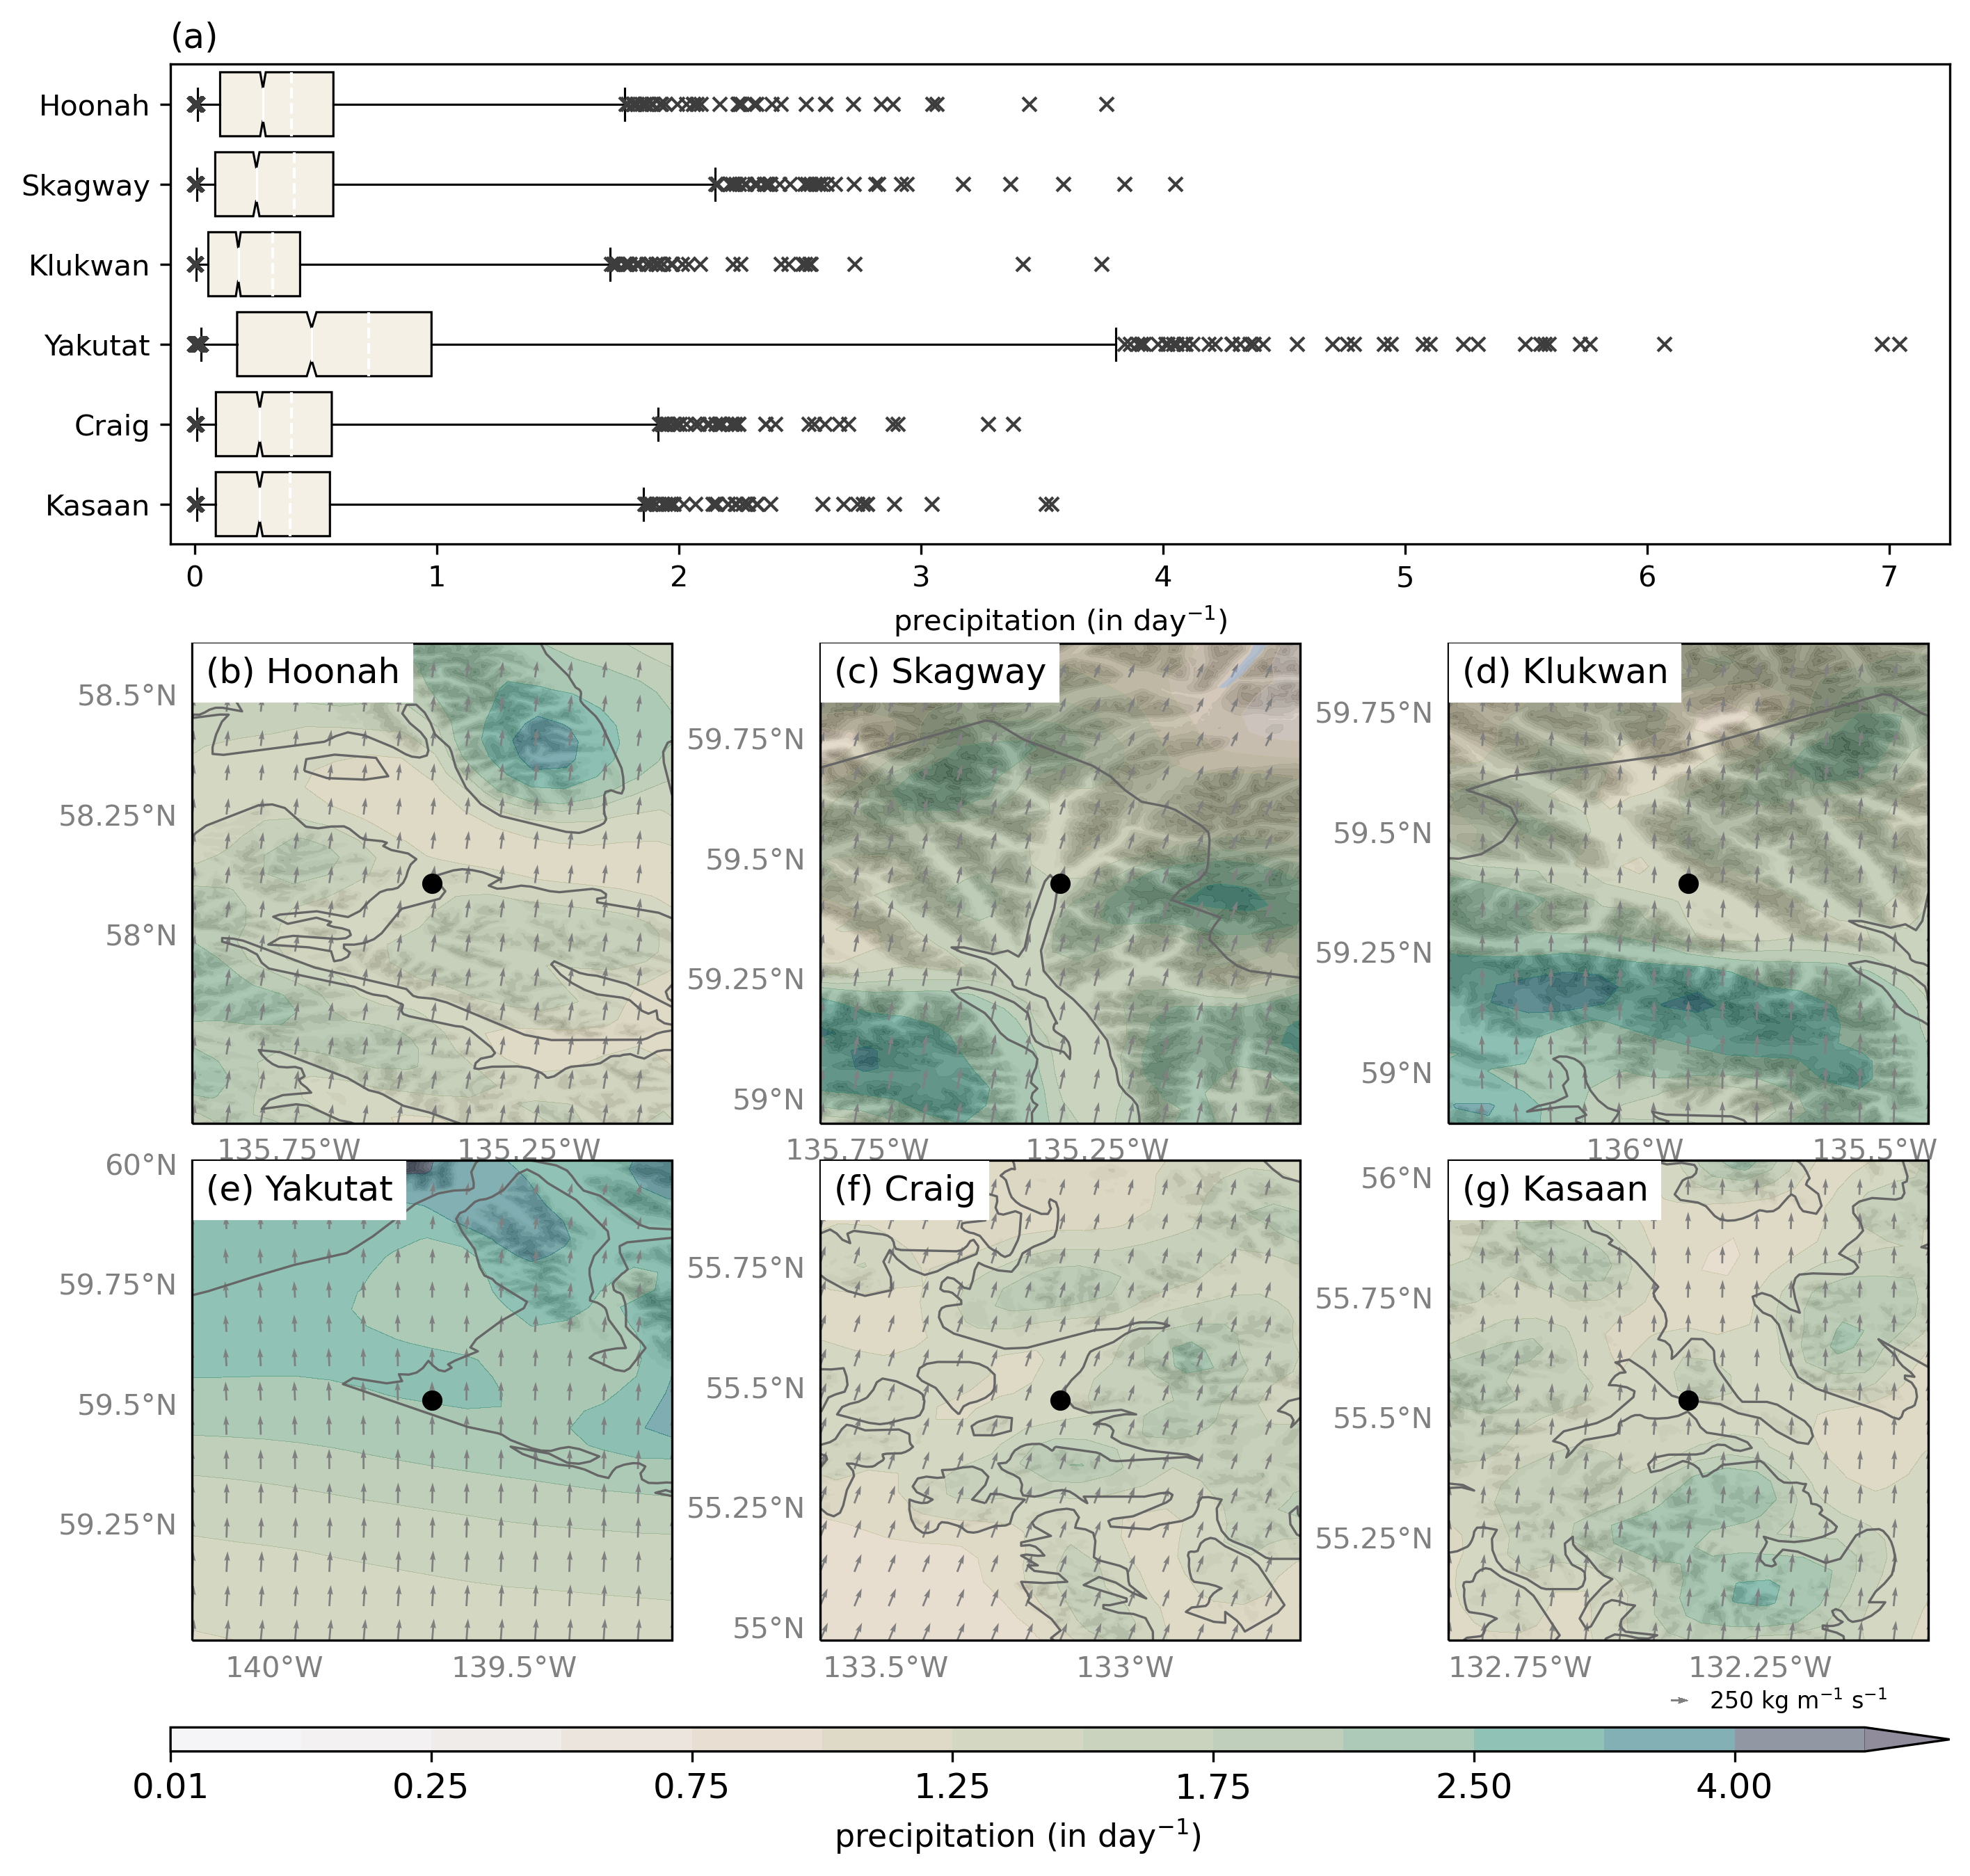

In [9]:
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
# Create figure
fig = plt.figure(figsize=(11, 10.5))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_prec_composite_all_{0}_supplement'.format(temporal_res)
fmt = 'png'

nrows = 6
ncols = 3

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 1, 1, 0.025, 0.05], width_ratios = [1, 1, 1], wspace=0.2, hspace=0.15)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
ax = fig.add_subplot(gs[0, :])
PROPS = {'boxprops':{'facecolor':'#F5F0E6', 'edgecolor':'k'},
         'medianprops':{"color": "white"},
         'whiskerprops':{"color": "k"},
         'capprops':{"color": "k"},
         'flierprops':{"marker": "x"},
         'meanprops':{'c':'white', 'lw':1}}

bplot = sns.boxplot(y="Community", x="Precipitation", data=df_tidy, whis=[5, 99],
                order=community_lst,
                meanline=True, showmeans=True, 
                notch=True, showcaps=True,
                linewidth=0.75,
                **PROPS)
    
plt.xlim(-0.1, 7.25)
    
ax.set_title('(a)', loc='left')
# ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
#         backgroundcolor='white', zorder=100)

ax.set_xlabel('precipitation (in day$^{-1}$)')
ax.set_ylabel('')

#########################
### PRECIP COMPOSITES ###
#########################

rowidx_lst = [2, 2, 2, 3, 3, 3]
colidx_lst = [0, 1, 2, 0, 1, 2]
for k, (rowidx, colidx) in enumerate(zip(rowidx_lst, colidx_lst)):
    ax = fig.add_subplot(gs[rowidx, colidx], projection=mapcrs)
    
    # Set tick/grid locations
    diff = 0.25
    ext = ext_lst[k]
    dx = np.arange(round(ext[0]),round(ext[1])+diff,diff)
    dy = np.arange(round(ext[2]),round(ext[3])+diff,diff)
    
    ds = prec_comp.sel(community=community_lst[k])
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)
    
    ## topo with grey-scale hillshade cmap
    # cs = ax.pcolormesh(elev.lon, elev.lat, elev.hillshade, rasterized=False, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.8)
    ## topo with grey-scale flat elevation
    clevs = np.arange(250, 3000, 250)
    cs = ax.contourf(elev.lon, elev.lat, elev.elev, transform=datacrs,
                     levels=clevs, cmap=cmo.gray_r, alpha=0.8, extend='both')
    
    # ## topo with contour lines
    # cs = ax.contour(elev.lon, elev.lat, elev.elev, transform=datacrs,
    #                 levels=clevs, colors='grey', linewidths=0.7)
    # plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

    # Contour Filled
    prec = ds.PCPT.values/25.4 # convert precip from mm to inch x/25.4
    print(np.nanmax(prec))
    if temporal_res == 'hourly':
        cflevs = np.arange(0.1, 2.2, 0.1)
        clabel = 'precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        cflevs = np.arange(0.0, 105, 5)
        ## inches daily precipitation cflevs
        cflevs = [0.01, 0.1, 0.25, 0.5, 0.75, 1., 1.25, 1.5, 1.75, 2.0, 2.5, 3., 4., 5.]
        clabel = 'precipitation (in day$^{-1}$)'
    cf = ax.contourf(ds.lon.values, ds.lat.values, prec, transform=datacrs,
                     levels=cflevs, cmap=cmo.rain, alpha=0.5, extend='max')
    
    # Wind barbs / vectors 
    # ivt = ivt_comp.sel(community=community_lst[k], lag=0, lat=slice(ext[3], ext[2]), lon=slice(ext[0], ext[1]))
    ivt = ivt_comp.sel(community=community_lst[k], lag=0)
    uvec = ivt.IVTu.values
    vvec = ivt.IVTv.values
    # uvec_mask = ivt.IVTu.where((ivt.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ivt.IVTv.where((ivt.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(ivt.lon, ivt.lat, uvec, vvec, transform=datacrs, 
              color='grey', regrid_shape=15,
              angles='xy', scale_units='xy', units='xy')
    
    
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    

    titlestring = '({0}) {1}'.format(letter_lst[k+1], community_lst[k])
    ax.text(0.029, 0.973, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ko', markersize=6, transform=datacrs)
    
# Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label(clabel, fontsize=11)
cb.ax.tick_params(labelsize=12)

# quiver key
qk = ax.quiverkey(Q, 0.5, -0.125, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()